# Defining the Question


### a) Specifying the Question

> Create a cross-lingual machine learning model focused on Political Hate Speech in Kenya which classifies whether an online post is deemed hate speech and the severity(sub-class) of it if so or not not hate speech (normal speech).

### b) Defining the Metric for Success



> An overall classification accuracy of 80% and Hate Class Recall of 70%.

### c) Understanding the context

> In an increasingly digital era where online social interactions are considered part of the social context, it is proving inevitable that machine learning should be used to protect people from harmful content. This has been evidenced by the multitude of instances where hate speech propagated online (mostly based on misinformation) has led to physical injury and loss of lives across the world. Government institutions should now consider online interactions as spaces where potential crimes may occur just like in the physical world.


> The goal of identifying hate speech efficiently and accurately irrespective of language is becoming a necessity. Countries like Kenya amongst other African nations have experienced the consequences of not dealing with hate speech as evidenced in previous years. Agencies such as the National Cohesion & Integration Commission were formed to help with this. Section 13 of National Cohesion and Integration Act(2008) outlines what is considered hate speech. In combination with the act an automated way of flagging hate speech would prove helpful for the institution given the country’s context which may not be similar to other countries meaning posts may not be picked/flagged by social media companies such as Twitter and Facebook as a result.


> Political hate speech is the greatest area of concern in regards to Kenya and thus we’ll be our area of focus. Looking at whether a post is Hate Speech or Normal Speech and it's severity (sub-class). 


### d) Recording the Experimental Design


> The following design was used:


* Data importation
* Data Reading & Pre-processing
* EDA
* Unsupervised Topic Modeling
* Semi-Supervised Hate Speech Detection
  - Optimization/Tuning


### e) Data Relevance

> This was evaluated against the metric of success (after implementation of solution)

# Data Preparation

### Importing our Libraries

In [1]:
# installing the necessary libraries not in google colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     \ 38.3MB 5.9MB/s
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 1.1MB 36.7MB/s 
     |████████████████████████████████| 3.2MB 40.2MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 296kB 49.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=05c32a1a9f207269f41352af614197a8cc8f754bb24352a17283b1ed840ecedd
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mpwj1lx/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=5655a1409edd4d3db50eabd5191db9c573e495a8a512b8b46ac2389f831b062e
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=

In [2]:
! pip install nltk

In [3]:
! pip install spacy

In [4]:
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
! pip install sparknlp

     |████████████████████████████████| 153kB 7.8MB/s 


In [6]:
# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

     |████████████████████████████████| 215.7MB 70kB/s 
     |████████████████████████████████| 204kB 20.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130389 sha256=1a4d4f499bb2ba27b353479211ea126d24b11046efe6da2060c1e39d614c156e
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [7]:
!pip install googletrans

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 1.0MB 8.8MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp37-none-any.whl size=15737 sha256=a75488fe45a27a5c41670e1d90002d49f169ebe39ffe42d88c16cf51ed05ca6d
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
Successfully built googletrans


In [8]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)


In [12]:
# Let us first import all the libraries we will need for our analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import re
from matplotlib import pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import norm
import math
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import nltk
import spacy
import sparknlp

In [10]:
# let us set the warnings that may appear in our analysis off

import warnings
warnings.filterwarnings('ignore') 

# subsequently let us set the pandas warning for chained assignments off
pd.options.mode.chained_assignment = None  # default='warn'

### Loading and Previewing our Dataset

In [ ]:
# Loading the Dataset from the source i.e. csv
a = pd.read_excel('/content/Friday_copy_hatespeech_sample_data2.xlsx')
b = pd.read_excel('/content/Thursday_copy_hatespeech_sample_data1.xlsx')

frames = [a, b]

df = pd.concat(frames)
df.head()

,user,tweet,"hate_speech(1=hspeech, 0=nohspeech)",location,description,friends_count,followers_count,statuses_count,tweet_date,retweet_count,likes,hashtags
0,timothymutuake,@Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...,1.0,machakos,This is the account of absolute Timothy Mutua,790.0,1675.0,19009.0,2021-04-15 06:35:29,0.0,1.0,[]
1,iamthe_mwas,@MissKwegah1 Luhyas group of food,0.0,Ruaka,"Drink water,eat alot of greens,drink water..,e...",810.0,448.0,6453.0,2021-04-15 06:19:57,0.0,1.0,[]
2,kwibita,"@smileycherry2 Don't beat around the bush, wal...",0.0,Nairobi,"Plumbing Engineer Design&Implementation,planni...",2744.0,1678.0,2316.0,2021-04-15 05:32:02,0.0,4.0,[]
3,ngalih_junior,@Cockey_ninja @AizoOzill Act of generosity whi...,0.0,"Nairobi, Kenya",Football Health and political enthusiast.,3270.0,800.0,129.0,2021-04-14 17:53:15,1.0,2.0,[]
4,allak_weda,@ArapTilingi Luos and Luhyas have been doing t...,0.0,Nairobi,Tech enthusiast & Lone ranger.,315.0,351.0,15017.0,2021-04-14 15:06:36,0.0,0.0,[]


## Checking the Data

In [ ]:
# Determining the no. of records in our  dataset
#
print('This hatespeeech dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')

This hatespeeech dataset has 1623 rows, and 12 columns


In [ ]:
# Checking whether each column has an appropriate datatype
#
df.dtypes

user                                           object
tweet                                          object
hate_speech(1=hspeech, 0=nohspeech)           float64
location                                       object
description                                    object
friends_count                                 float64
followers_count                               float64
statuses_count                                float64
tweet_date                             datetime64[ns]
retweet_count                                 float64
likes                                         float64
hashtags                                       object
dtype: object

In [ ]:
# checking the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623 entries, 0 to 685
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   user                                 1622 non-null   object        
 1   tweet                                1622 non-null   object        
 2   hate_speech(1=hspeech, 0=nohspeech)  995 non-null    float64       
 3   location                             1603 non-null   object        
 4   description                          1458 non-null   object        
 5   friends_count                        1622 non-null   float64       
 6   followers_count                      1622 non-null   float64       
 7   statuses_count                       1622 non-null   float64       
 8   tweet_date                           1622 non-null   datetime64[ns]
 9   retweet_count                        1622 non-null   float64       
 10  likes        

In [ ]:
# let us see the columns in our dataframe
df.columns

Index(['user', 'tweet', 'hate_speech(1=hspeech, 0=nohspeech)', 'location',
       'description', 'friends_count', 'followers_count', 'statuses_count',
       'tweet_date', 'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# Checking the entire profile of the dataframe
profile = ProfileReport(df, title="Tweets Profile Report", html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# let us save our profile report
profile.to_file(output_file="Tweets_Profile_Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
df_copy = df.copy(deep = True)

In [ ]:
# For consistency, the column names should be uniform
# Let us change all column names to lower case
#
df_copy.columns = df_copy.columns.str.lower()
# Previewing the columns to confirm whether the changes have taken effect
#
df_copy.columns

Index(['user', 'tweet', 'hate_speech(1=hspeech, 0=nohspeech)', 'location',
       'description', 'friends_count', 'followers_count', 'statuses_count',
       'tweet_date', 'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# let us replace the hatespeech column name
df_copy.rename(columns = {'hate_speech(1=hspeech, 0=nohspeech)': 'hate_speech'}, inplace=True)
df_copy.columns 

Index(['user', 'tweet', 'hate_speech', 'location', 'description',
       'friends_count', 'followers_count', 'statuses_count', 'tweet_date',
       'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# let us check for duplicates
df_copy.duplicated().sum()

56

In [ ]:
# let us drop the duplicates
df_copy.drop_duplicates(inplace=True)
df_copy.duplicated().sum()

0

In [ ]:
# Let Us Drop the columns that do contribute to 
# whether a passenger survives or not 

df_copy.drop(['user','description', 'hashtags'], axis=1, inplace=True)

# let us confirm that we have dropped the unnecessary columns
df_copy.head()

,tweet,hate_speech,location,friends_count,followers_count,statuses_count,tweet_date,retweet_count,likes
0,@Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...,1.0,machakos,790.0,1675.0,19009.0,2021-04-15 06:35:29,0.0,1.0
1,@MissKwegah1 Luhyas group of food,0.0,Ruaka,810.0,448.0,6453.0,2021-04-15 06:19:57,0.0,1.0
2,"@smileycherry2 Don't beat around the bush, wal...",0.0,Nairobi,2744.0,1678.0,2316.0,2021-04-15 05:32:02,0.0,4.0
3,@Cockey_ninja @AizoOzill Act of generosity whi...,0.0,"Nairobi, Kenya",3270.0,800.0,129.0,2021-04-14 17:53:15,1.0,2.0
4,@ArapTilingi Luos and Luhyas have been doing t...,0.0,Nairobi,315.0,351.0,15017.0,2021-04-14 15:06:36,0.0,0.0


In [ ]:
# let us check for missing values in our dataframe
null_list = list(df_copy.columns.values)

for n in null_list:
    print (n,": ",sum(pd.isnull(df_copy[n])))
#We have 177 NaN in Age and 2 in Embarked.

tweet :  1
hate_speech :  626
location :  19
friends_count :  1
followers_count :  1
statuses_count :  1
tweet_date :  1
retweet_count :  1
likes :  1


In [ ]:
# let us see how much information we lose by dropping the null values
df_clean = df_copy.dropna()
print('Shape of dataframe with no missing values: ', df_clean.shape)
print('Shape of dataframe with missing values: ', df_copy.shape)
# by dropping our null values we have dropped just 80 rows of our dataframe
# this is not a significant part of our dataset which is ideal
# therefore we will work with the clean dataframe

Shape of dataframe with no missing values:  (929, 9)
Shape of dataframe with missing values:  (1567, 9)


In [ ]:
df_clean.isnull().sum()

tweet              0
hate_speech        0
location           0
friends_count      0
followers_count    0
statuses_count     0
tweet_date         0
retweet_count      0
likes              0
dtype: int64

In [ ]:
#export cleanfile to csv
df_clean.to_csv('clean_hatespeech1.csv')

# Exploratory Data Analysis

In [ ]:
# let us see some info on our dataset
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 681
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            929 non-null    object        
 1   hate_speech      929 non-null    float64       
 2   location         929 non-null    object        
 3   friends_count    929 non-null    float64       
 4   followers_count  929 non-null    float64       
 5   statuses_count   929 non-null    float64       
 6   tweet_date       929 non-null    datetime64[ns]
 7   retweet_count    929 non-null    float64       
 8   likes            929 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 72.6+ KB


In [ ]:
# let us see some summary statistics of the dataset
df_clean.describe()

,hate_speech,friends_count,followers_count,statuses_count,retweet_count,likes
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.419806,1896.872982,6053.461787,14365.489774,1.916039,11.162540
std,0.493793,5242.163831,37985.611785,39036.186342,18.256891,93.899401
min,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,0.000000,280.000000,164.000000,961.000000,0.000000,0.000000
50%,0.000000,747.000000,550.000000,3080.000000,0.000000,1.000000
75%,1.000000,2060.000000,2440.000000,12202.000000,0.000000,2.000000
max,1.000000,135576.000000,906820.000000,663554.000000,445.000000,2312.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3f4bd6090>,
      dtype=object)

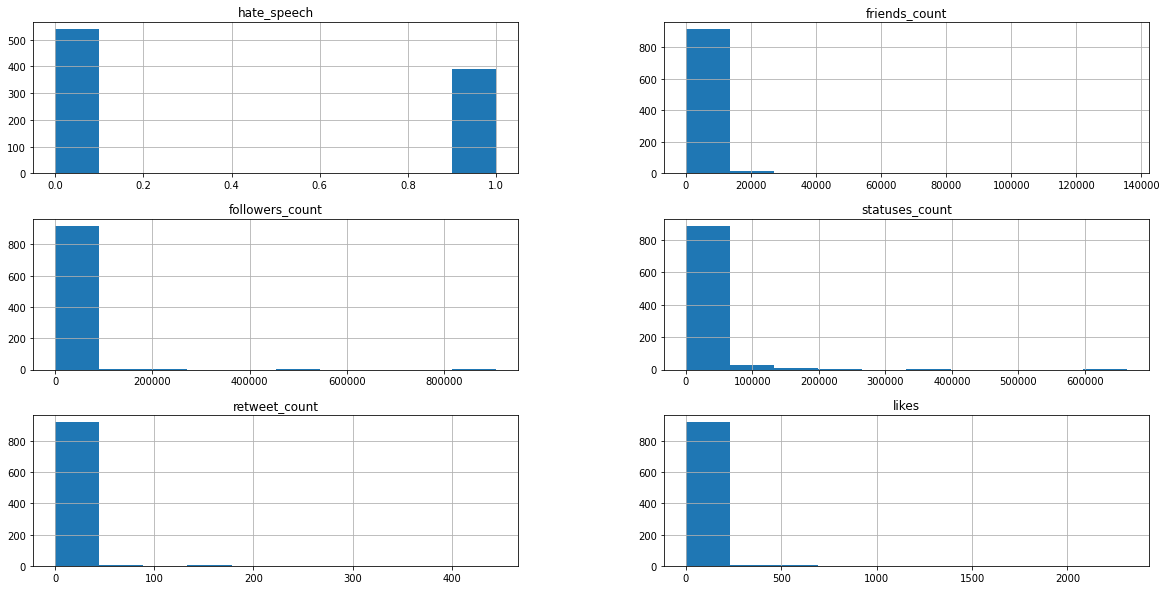

In [ ]:
# let us plot histograms to visualize patterns in the data
df_clean.hist(figsize = (20,10))

Text(0.5, 1.0, 'Checking for outliers using boxplots')

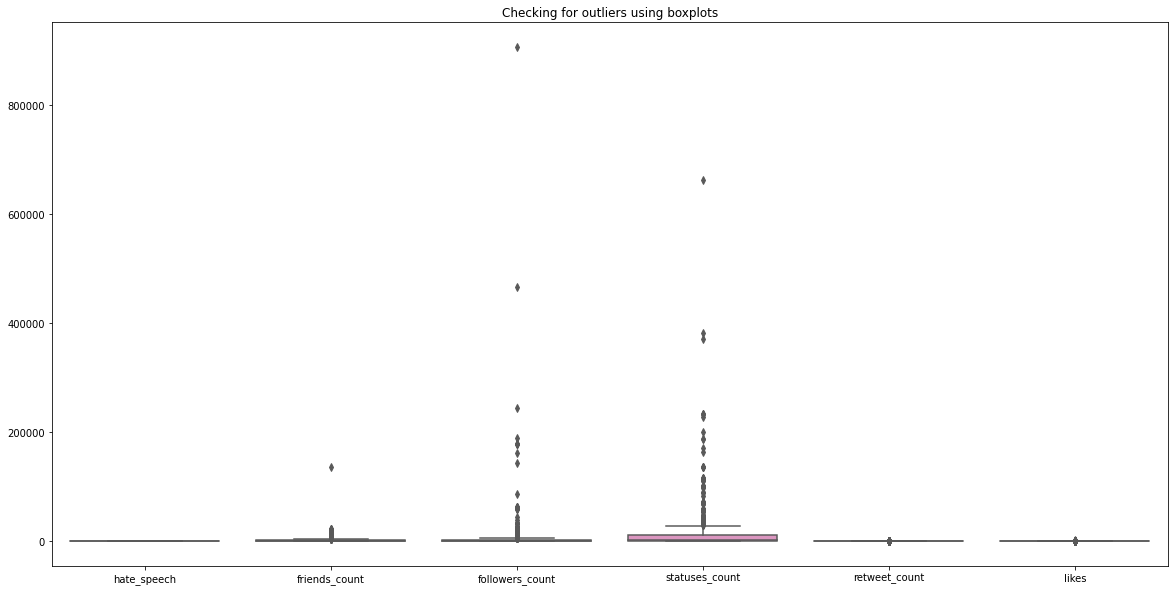

In [ ]:
# Boxplots to Visualize outliers of our numerical columns 
plt.figure(figsize = (20,10))
ax = sns.boxplot(data=df_clean, orient="v", palette="Set2")
plt.title('Checking for outliers using boxplots')
# The boxplots below indicate the outliers in each of the numerical columns

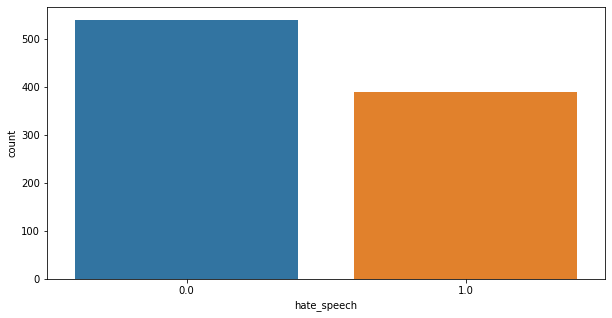

In [ ]:
# let us see how the labels are distributed in our dataset
plt.figure(figsize=(10,5))
sns.countplot(x="hate_speech", data = df_clean)

# normal speech is greater than hatespeech 

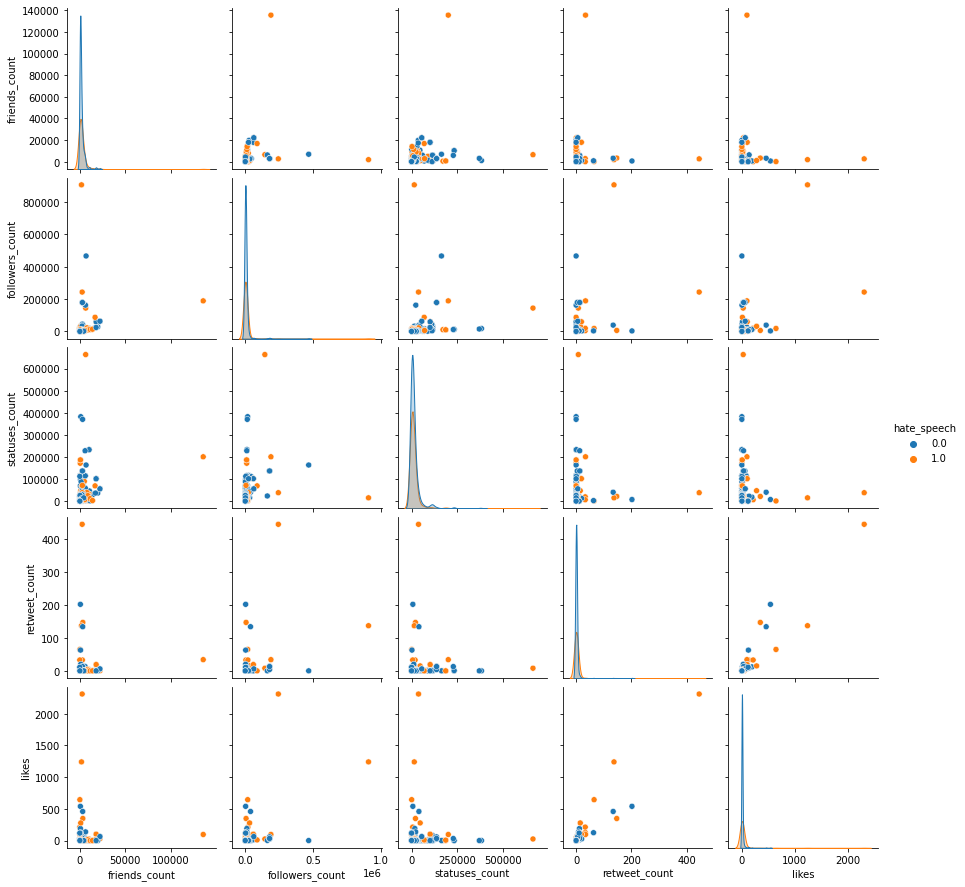

In [ ]:
# Ploting the bivariate summaries and recording our observations
sns.pairplot(df_clean, hue="hate_speech")
plt.show()

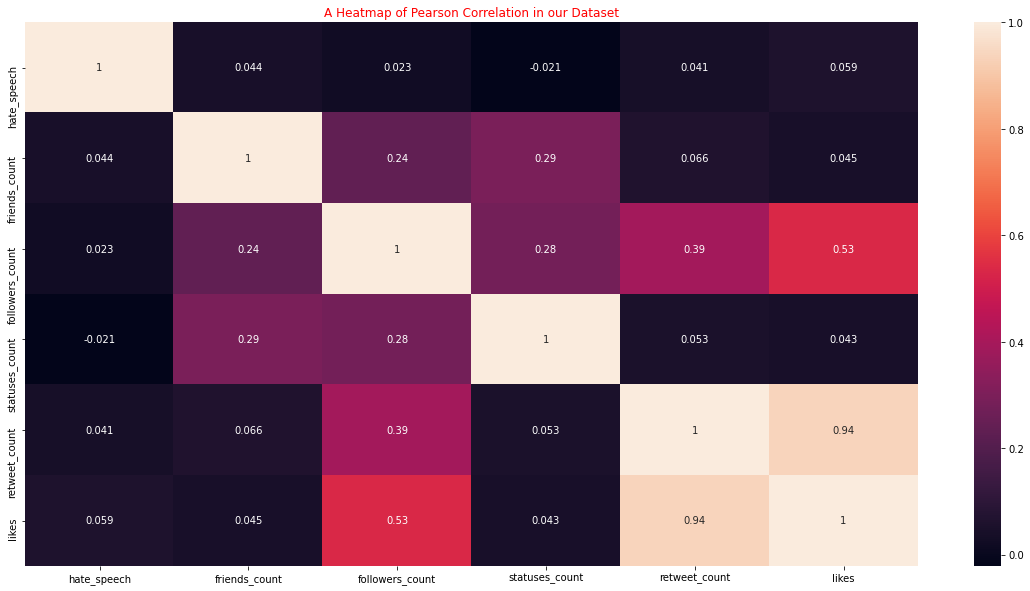

In [ ]:
# Calculating the pearson coefficient correlation
a = df_clean.corr() 
plt.figure(figsize = (20,10))
sns.heatmap(a, xticklabels=a.columns, yticklabels=a.columns, annot=True)
plt.title('A Heatmap of Pearson Correlation in our Dataset', color='red')
plt.show()
# From this we can see there is a correlation between t3 and tt4.

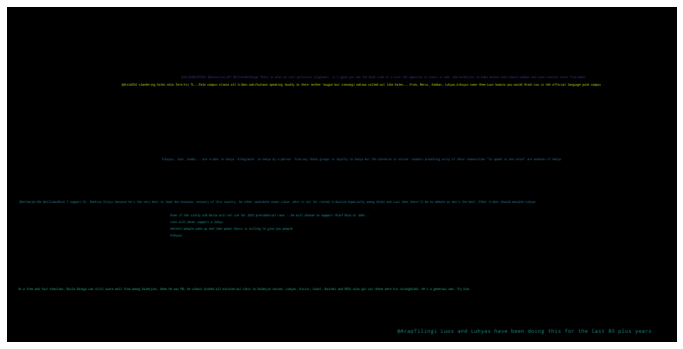

In [ ]:
# Most common words
from wordcloud import WordCloud
from nltk import FreqDist
#Frequency of words
fdist = FreqDist(df_clean['tweet'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Data Pre-Processing

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
data = df_clean.copy(deep = True)

In [ ]:
# let us change the data type of our tweet column
data.info()
data.tweet= data.tweet.astype(str)
data.hate_speech = data.hate_speech.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 681
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            929 non-null    object        
 1   hate_speech      929 non-null    object        
 2   location         929 non-null    object        
 3   friends_count    929 non-null    float64       
 4   followers_count  929 non-null    float64       
 5   statuses_count   929 non-null    float64       
 6   tweet_date       929 non-null    datetime64[ns]
 7   retweet_count    929 non-null    float64       
 8   likes            929 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 92.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 681
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            929 non-n

In [ ]:
# let us create a dataset with only our columns of interest 
tweets = data[['tweet', 'hate_speech']]
tweets.head()

,tweet,hate_speech
0,@Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...,1.0
1,@MissKwegah1 Luhyas group of food,0.0
2,"@smileycherry2 Don't beat around the bush, wal...",0.0
3,@Cockey_ninja @AizoOzill Act of generosity whi...,0.0
4,@ArapTilingi Luos and Luhyas have been doing t...,0.0


In [ ]:
# let us make a copy of our dataset to clean and do modelling on
copy1 = tweets.copy(deep=True)

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
copy2 = tweets.copy(deep=True)

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
tweets_c = tweets.copy(deep=True)

### Google translate

In [ ]:
#cleaning so as to translate
# Using regex 

# Converting all characters in the tweet to lower case
#tweets_c['tweet'] = tweets_c.tweet.map(lambda x: x.lower())

#url removes
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
tweets_c['tweet']= tweets_c['tweet'].str.replace(r'www\.\S+\.com','')

#removes retweets & cc
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'rt|cc', '')

#hashtags removes
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'#\S+', '')

#user mention removes
tweets_c['tweet'] =tweets_c['tweet'].str.replace(r'@\S+', '')

#emoji 
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'[^\x00-\x7F]+', '')

#html tags
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'<.*?>', '')

#removes extra spaces
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r' +', ' ')

#punctuation
tweets_c['tweet'] = tweets_c['tweet'].str.replace('[^\w\s]', '').astype(str) 

#convert preprocessed list words to string 
tweets_c['tweet'] = tweets_c['tweet'].apply(''.join)

In [ ]:
!pip install google_trans_new

In [ ]:
from spacy.lang.en import English

nlp = English()

#convert tweet column to list
twl_1 = list(tweets_c.tweet)

from google_trans_new import google_translator  
translator = google_translator()  

#empyt list to hold translated tweets
trans_l = []

#iterate over each tweet to translate
for x in range(len(twl_1)):
  translate_text = translator.translate(twl_1[x],lang_src='sw', lang_tgt='en')  
  trans_l.append(translate_text)

#create a dataframe to hold the translated tweets
trans_ldf = pd.DataFrame(trans_l, columns=['transl_tweet'])
trans_ldf

#append it as a column back to the original dataframe and drop non-translated col
#reset the original df index
tweets_c.reset_index(inplace=True)
tweets_c['transl_tweet']= trans_ldf
tweets_ct = tweets_c.drop('tweet', axis=1)

In [ ]:
#lowercase the translated tweets
trans_ldf.transl_tweet = trans_ldf.transl_tweet.str.lower()

In [ ]:
# let us export the translated tweets to a csv file
trans_ldf.to_csv('translated_hatespeech.csv')

In [ ]:
# let us export the translated tweets to a csv file
tweets_ct.to_csv('tweetsct_hatespeech.csv')

In [ ]:
#tokenizer, pos tagging and entity recognition
nlp = spacy.load('en')

trans_ldf.transl_tweet  = trans_ldf.transl_tweet.apply(lambda x: nlp(x))

In [ ]:
#stemming/lemmatization
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(lambda x: [item.lemma_ for item in x ])

In [ ]:
#remove stop words
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

#remove stopwords
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(lambda x: [item for item in x if item not in all_stopwords])

#convert preprocessed list words to string 
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(' '.join)

In [ ]:
#append to df and drop col
tweets_ct['tweet'] = trans_ldf
final = tweets_ct.drop(['index','transl_tweet'], axis=1)
final

,hate_speech,tweet
0,1.0,point correction kambas practise witchcraft pa...
1,0.0,luhyas group food
2,0.0,beat bush waluhya character
3,0.0,act generosity common kambas
4,0.0,luos luhyas 80 plus year
...,...,...
924,0.0,tribal politic end excuse intimidation deter -...
925,0.0,remember know -PRON- history -PRON- opinion ch...
926,0.0,itasettle tribal politic .
927,0.0,believe -PRON- somalis word democratic politic...


In [ ]:
final.to_csv('final_hatespeech.csv')

# Importing translated cleaned dataset

In [15]:
import pandas as pd
final = pd.read_csv('/content/final_hatespeech.csv')
#final.drop('Unnamed: 0', inplace= True)
final.head()

,Unnamed: 0,hate_speech,tweet
0,0,1.0,point correction kambas practise witchcraft pa...
1,1,0.0,luhyas group food
2,2,0.0,beat bush waluhya character
3,3,0.0,act generosity common kambas
4,4,0.0,luos luhyas 80 plus year


In [21]:
final.isnull().sum()
final.dropna(inplace=True)
final.isnull().sum()

Unnamed: 0     0
hate_speech    0
tweet          0
dtype: int64

In [22]:
# let us make a copy of our dataset to clean and do modelling on
final_copy = final.copy(deep=True)

In [23]:
# let us make a copy of our dataset to clean and do modelling on
df1 = final_copy.copy(deep=True)

In [24]:
# let us make a copy of our dataset to clean and do modelling on
df = final_copy.copy(deep=True)

In [25]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 
from sklearn.feature_extraction.text import CountVectorizer 
# build a vocabulary that only consider the top max_features ordered by the term frequency across the column
vectorizer = CountVectorizer(max_features=100)
# the function fit_transform() is used for dataset transformation in scikit learn
x = vectorizer.fit_transform(df.tweet).toarray()
y = df.hate_speech.values

# This

In [33]:
# compare algorithms
from matplotlib import pyplot
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# split the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=0)

# #scale the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train) 
# X_test = sc.transform(X_test)

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.618630 (0.063569)
LDA: 0.616295 (0.057550)
KNN: 0.532495 (0.040885)
CART: 0.566124 (0.056110)
RF: 0.588288 (0.067321)
GBC: 0.613477 (0.067205)
NB: 0.585561 (0.057804)
SVM: 0.621263 (0.076964)
XGB: 0.649926 (0.062178)


# Naive Bayes Model

In [27]:
# Training the Model
# We will start by splitting our data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Fitting our model 
# Then, all that we have to do is initialize the Naive Bayes Classifier and fit the data. 
# For text classification problems, the Multinomial Naive Bayes Classifier is well-suited
# 
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

# Evaluating the Model
# Once we have put together our classifier, we can evaluate its performance in the testing set
# 
predicted = model.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, predicted)}')
print(f'The auc score is: {roc_auc_score(y_test, predicted)}')
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

The accuracy score is: 0.6344086021505376
The auc score is: 0.6158558558558559
[[79 32]
 [36 39]]
              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70       111
         1.0       0.55      0.52      0.53        75

    accuracy                           0.63       186
   macro avg       0.62      0.62      0.62       186
weighted avg       0.63      0.63      0.63       186



In [28]:
# Training our model and printing out metrics
# 
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()  
model = clf.fit(X_train, y_train) 
predicted = model.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, predicted)}')
print(f'The auc score is: {roc_auc_score(y_test, predicted)}')
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

The accuracy score is: 0.6075268817204301
The auc score is: 0.6041441441441441
[[69 42]
 [31 44]]
              precision    recall  f1-score   support

         0.0       0.69      0.62      0.65       111
         1.0       0.51      0.59      0.55        75

    accuracy                           0.61       186
   macro avg       0.60      0.60      0.60       186
weighted avg       0.62      0.61      0.61       186



# Random Forest Model

In [35]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


# Import the model
from sklearn.ensemble import RandomForestClassifier

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
forest = RandomForestClassifier(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=5)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6505376344086021
The auc score is: 0.583963963963964
[[103   8]
 [ 57  18]]
              precision    recall  f1-score   support

         0.0       0.64      0.93      0.76       111
         1.0       0.69      0.24      0.36        75

    accuracy                           0.65       186
   macro avg       0.67      0.58      0.56       186
weighted avg       0.66      0.65      0.60       186



In [30]:
# We will start by splitting our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# # define dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#                            n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define pipeline
steps = [('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))
print(mean(scores))

0.6000404653968595


# SVM 

In [37]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6559139784946236
The auc score is: 0.6252252252252253
[[87 24]
 [40 35]]
              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73       111
         1.0       0.59      0.47      0.52        75

    accuracy                           0.66       186
   macro avg       0.64      0.63      0.63       186
weighted avg       0.65      0.66      0.65       186



In [38]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6397849462365591
The auc score is: 0.6009009009009009
[[89 22]
 [45 30]]
              precision    recall  f1-score   support

         0.0       0.66      0.80      0.73       111
         1.0       0.58      0.40      0.47        75

    accuracy                           0.64       186
   macro avg       0.62      0.60      0.60       186
weighted avg       0.63      0.64      0.62       186



In [39]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6236559139784946
The auc score is: 0.5571171171171171
[[100  11]
 [ 59  16]]
              precision    recall  f1-score   support

         0.0       0.63      0.90      0.74       111
         1.0       0.59      0.21      0.31        75

    accuracy                           0.62       186
   macro avg       0.61      0.56      0.53       186
weighted avg       0.61      0.62      0.57       186



In [40]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.510752688172043
The auc score is: 0.4906306306306306
[[66 45]
 [46 29]]
              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59       111
         1.0       0.39      0.39      0.39        75

    accuracy                           0.51       186
   macro avg       0.49      0.49      0.49       186
weighted avg       0.51      0.51      0.51       186



# LSTM